In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import requests

In [10]:
wm_title=[]  
wm_date = []
wm_content = []
wm_rating = []

In [11]:
for i in range(1,100):
    ip=[]  
    url="https://www.amazon.in/Smart-AMOLED-Display-Battery-Resistant/product-reviews/B08GXC2NTX/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews"+str(i)
    response = requests.get(url)
    soup = bs(response.content,"html.parser")# creating soup object to iterate over the extracted content 

In [12]:
#Extracting Content of review
review = soup.find_all("span",{"data-hook":"review-body"})
review_content = []
for i in range(0,len(review)):
    review_content.append(review[i].get_text())
review_content[:] = [reviews.lstrip('\n') for reviews in review_content]
review_content[:] = [reviews.rstrip('\n') for reviews in review_content]
wm_content = wm_content + review_content  


In [13]:
# extracting Review Title
title = soup.find_all('a',class_='review-title-content')
review_title = []
for i in range(0,len(title)):
    review_title.append(title[i].get_text())
review_title[:] = [titles.lstrip('\n') for titles in review_title]
review_title[:] = [titles.rstrip('\n') for titles in review_title]
wm_title = wm_title + review_title
  
  

In [14]:
# Extracting Ratings
rating = soup.find_all('i',class_='review-rating')
review_rating = []
for i in range(2,len(rating)):
    review_rating.append(rating[i].get_text())
  #review_rating.pop(0)
  #review_rating.pop(0)
review_rating[:] = [reviews.rstrip(' out of 5 stars') for reviews in review_rating]
wm_rating = wm_rating + review_rating  
  
  

In [15]:
#Extracting dates of reviews
dates = soup.find_all('span',class_='review-date')
review_dates = []
for i in range(2,len(rating)):
    review_dates.append(dates[i].get_text())
review_dates[:] = [reviews.lstrip('Reviewed in India on') for reviews in review_dates]
#review_dates.pop(0)
#review_dates.pop(0)
wm_date  = wm_date + review_dates
  

In [16]:
print(len(wm_title))
print(len(wm_rating))
print(len(wm_content))
print(len(wm_date))



10
10
10
10


In [42]:
df = pd.DataFrame()
df['Title'] = wm_title
df['Ratings'] = wm_rating
df['Comments'] = wm_content
df['Date'] = wm_date


In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df['Ratings'] = df['Ratings'].astype(float)
df.head()


,Title,Ratings,Comments,Date
0,Complete detailed review and comparison with M...,5.0,"This is going to be a long review, scroll to...",2020-10-05
1,Get Fit,5.0,Been Using Amazfit Bip since a Year which ha...,2020-10-03
2,Good enough but,4.0,- Step count is above 75% accurate. it even...,2020-10-05
3,"Bad experience,not accurate.",1.0,Your browser does not support HTML5 video.\n...,2020-10-04
4,Please folks save your money for real!,1.0,"I've been using mi band 2,3,4 and this one o...",2020-10-06


In [44]:
from nltk.corpus import wordnet


In [45]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    

In [46]:
import string
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [47]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [48]:
# clean text data
df["Comments"] = df["Comments"].apply(lambda x: clean_text(x))
df['Title'] = df['Title'].astype(str)
df['Title'] = df['Title'].apply(lambda x: clean_text(x))
df.head()

,Title,Ratings,Comments,Date
0,complete detail review comparison mi band,5.0,go long review scroll end summery i've already...,2020-10-05
1,get fit,5.0,use amazfit bip since year limit activity trac...,2020-10-03
2,good enough,4.0,step count accurate even show step wake mornin...,2020-10-05
3,"bad experience,not accurate",1.0,"browser support video.\n\n\n it's accurate,an...",2020-10-04
4,please folk save money real,1.0,i've use mi band one obviously i'm pleased rep...,2020-10-06


In [49]:
#  add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [50]:
sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["Comments"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)
df

,Title,Ratings,Comments,Date,neg,neu,pos,compound
0,complete detail review comparison mi band,5.0,go long review scroll end summery i've already...,2020-10-05,0.047,0.733,0.220,0.9982
1,get fit,5.0,use amazfit bip since year limit activity trac...,2020-10-03,0.031,0.700,0.269,0.9822
2,good enough,4.0,step count accurate even show step wake mornin...,2020-10-05,0.022,0.754,0.223,0.9246
3,"bad experience,not accurate",1.0,"browser support video.\n\n\n it's accurate,an...",2020-10-04,0.116,0.795,0.089,-0.2023
4,please folk save money real,1.0,i've use mi band one obviously i'm pleased rep...,2020-10-06,0.079,0.757,0.164,0.6808
5,could better,4.0,share first impression lack sensor stage intro...,2020-10-03,0.083,0.726,0.191,0.8834
6,best mi band yet,5.0,best price segment great feature big screen ma...,2020-10-04,0.112,0.617,0.271,0.8306
7,band ok strap quality downgrade,1.0,use mi band order band first thing miss upon u...,2020-10-10,0.120,0.815,0.066,-0.5256
8,probably best price segment,5.0,always skeptical fitness band still think fitn...,2020-10-05,0.070,0.688,0.242,0.9712
9,awesome,5.0,step cound heart rate work super fine pai extr...,2020-10-03,0.074,0.560,0.366,0.8360


In [51]:
# add number of characters column
df["nb_chars"] = df["Comments"].apply(lambda x: len(x))
df

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars
0,complete detail review comparison mi band,5.0,go long review scroll end summery i've already...,2020-10-05,0.047,0.733,0.220,0.9982,3051
1,get fit,5.0,use amazfit bip since year limit activity trac...,2020-10-03,0.031,0.700,0.269,0.9822,844
2,good enough,4.0,step count accurate even show step wake mornin...,2020-10-05,0.022,0.754,0.223,0.9246,396
3,"bad experience,not accurate",1.0,"browser support video.\n\n\n it's accurate,an...",2020-10-04,0.116,0.795,0.089,-0.2023,189
4,please folk save money real,1.0,i've use mi band one obviously i'm pleased rep...,2020-10-06,0.079,0.757,0.164,0.6808,475
5,could better,4.0,share first impression lack sensor stage intro...,2020-10-03,0.083,0.726,0.191,0.8834,560
6,best mi band yet,5.0,best price segment great feature big screen ma...,2020-10-04,0.112,0.617,0.271,0.8306,265
7,band ok strap quality downgrade,1.0,use mi band order band first thing miss upon u...,2020-10-10,0.120,0.815,0.066,-0.5256,335
8,probably best price segment,5.0,always skeptical fitness band still think fitn...,2020-10-05,0.070,0.688,0.242,0.9712,778
9,awesome,5.0,step cound heart rate work super fine pai extr...,2020-10-03,0.074,0.560,0.366,0.8360,147


In [52]:
# add number of words column
df["nb_words"] = df["Comments"].apply(lambda x: len(x.split(" ")))
df

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words
0,complete detail review comparison mi band,5.0,go long review scroll end summery i've already...,2020-10-05,0.047,0.733,0.220,0.9982,3051,467
1,get fit,5.0,use amazfit bip since year limit activity trac...,2020-10-03,0.031,0.700,0.269,0.9822,844,111
2,good enough,4.0,step count accurate even show step wake mornin...,2020-10-05,0.022,0.754,0.223,0.9246,396,61
3,"bad experience,not accurate",1.0,"browser support video.\n\n\n it's accurate,an...",2020-10-04,0.116,0.795,0.089,-0.2023,189,26
4,please folk save money real,1.0,i've use mi band one obviously i'm pleased rep...,2020-10-06,0.079,0.757,0.164,0.6808,475,76
5,could better,4.0,share first impression lack sensor stage intro...,2020-10-03,0.083,0.726,0.191,0.8834,560,88
6,best mi band yet,5.0,best price segment great feature big screen ma...,2020-10-04,0.112,0.617,0.271,0.8306,265,41
7,band ok strap quality downgrade,1.0,use mi band order band first thing miss upon u...,2020-10-10,0.120,0.815,0.066,-0.5256,335,56
8,probably best price segment,5.0,always skeptical fitness band still think fitn...,2020-10-05,0.070,0.688,0.242,0.9712,778,116
9,awesome,5.0,step cound heart rate work super fine pai extr...,2020-10-03,0.074,0.560,0.366,0.8360,147,25


In [53]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


In [54]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["Comments"].apply(lambda x: x.split(" ")))]


In [55]:
# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)


In [56]:
# transform each Comment into a vector data
doc2vec_df = df["Comments"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)


In [57]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 6)
tfidf_result = tfidf.fit_transform(df["Comments"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)



In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


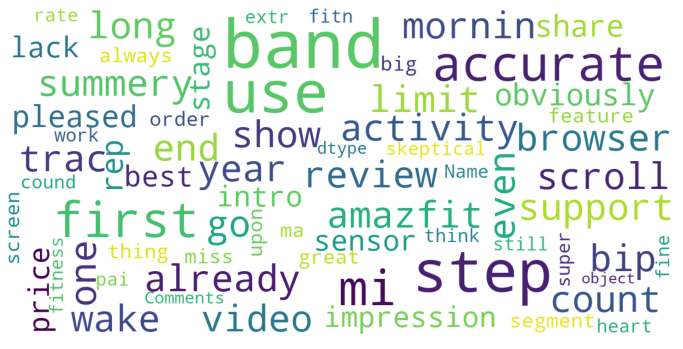

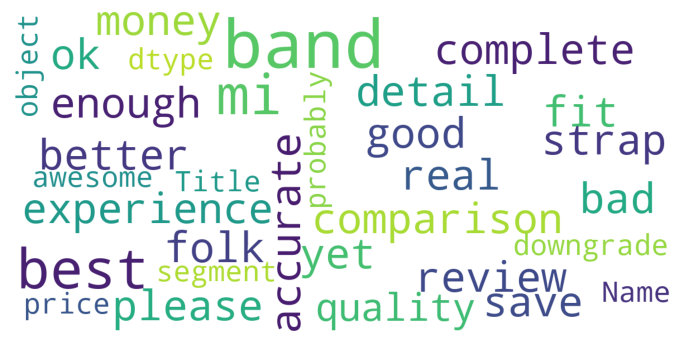

In [59]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 15)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(df["Comments"])
show_wordcloud(df["Title"])


In [60]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["Comments","neg"]].head(10)


,Comments,neg
7,use mi band order band first thing miss upon u...,0.120
3,"browser support video.\n\n\n it's accurate,an...",0.116
6,best price segment great feature big screen ma...,0.112
5,share first impression lack sensor stage intro...,0.083
4,i've use mi band one obviously i'm pleased rep...,0.079
9,step cound heart rate work super fine pai extr...,0.074
8,always skeptical fitness band still think fitn...,0.070
0,go long review scroll end summery i've already...,0.047
1,use amazfit bip since year limit activity trac...,0.031
2,step count accurate even show step wake mornin...,0.022


In [61]:
 # highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["Comments", "pos"]].head(10)



,Comments,pos
9,step cound heart rate work super fine pai extr...,0.366
6,best price segment great feature big screen ma...,0.271
1,use amazfit bip since year limit activity trac...,0.269
8,always skeptical fitness band still think fitn...,0.242
2,step count accurate even show step wake mornin...,0.223
0,go long review scroll end summery i've already...,0.220
5,share first impression lack sensor stage intro...,0.191
4,i've use mi band one obviously i'm pleased rep...,0.164
3,"browser support video.\n\n\n it's accurate,an...",0.089
7,use mi band order band first thing miss upon u...,0.066
